<div style="text-align: right">
    <h1> Assignment 1 </h1>
    <h1> Bhavi Dhingra </h1>
    <h1> 2018201058 </h1>
</div>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import heapq
import copy
from scipy import linalg
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

## 1.1 Direct Linear Transform

In this part we use all the points to estimate the projection matrix P . In the given picture there are 48 points of interest. For 
every real world poitns there is a corresponding image point. Using this mapping of points we can arrive at a set of equations
which will solve the problem of finding $\textit{P}$. <br>
Let $(u_i, v_i)$ be the image points corresponding to a real world point $(X_i, Y_i, Z_i)$ . Then representing both in homogenous
coordinate system.

$$
\begin{bmatrix} x_i \\ y_i \\ w_i \end{bmatrix} = P\begin{bmatrix} X_i \\ Y_i \\ Z_i \\ 1\end{bmatrix}
$$

where $(u_i, v_i) = (x_i / w_i, y_i / w_i)$. If $P_{11}, P_{12}, P_{13} ...$ represent the elements of the $P$ matrix we can formulate the problem into a set of equation by observing that.

$$u_i = \frac{x_i}{w_i} = \frac{P_{11} X_i + P_{12} Y_i + P_{13} Z_i + P_{14}}{P_{31} X_i + P_{32} Y_i + P_{33} Z_i + P_{34}}$$

and similarly

$$v_i = \frac{y_i}{w_i} = \frac{P_{21} X_i + P_{22} Y_i + P_{23} Z_i + P_{24}}{P_{31} X_i + P_{32} Y_i + P_{33} Z_i + P_{34}}$$

The rewriting everything into a set of equations we get.

$$
\begin{bmatrix} X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -u_{i}X_{i} & -u_{i}Y_{i} & -u_{i}Z_{i} & -u_{i} \\ 0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -v_{i}X_{i} & -v_{i}Y_{i} & -v_{i}Z_{i} & -v_i\end{bmatrix}\begin{bmatrix} P_{11} \\ P_{12} \\ P_{13} \\ . \\ . \\ . \\ P_{34}\end{bmatrix} = 0
$$

$$MP = 0$$

Since there are 12 unknowns and each mapping of real points to image points gives us 2 equations we need at least 6 of
these points to find a non trivial solution to the system of equations. Since the system of equations is a degenerate one we
need to find a vector of minimum euclidean norm that lies in the null space of $M$ . We do this by svd decomposition of $M = USV^T$
and than taking the last column of $V^T$ as the required vector.<br>

Once we have found the required P matrix we scale it by dividing every element by P 34 . Now we have

$$P = [K R|K RT ]$$

where $K$ is the internal camera matrix(intrinsic parameters), $R$ is the rotation matrix and $T$ is the translation vector of the camera from the world origin.

$$K = \begin{bmatrix} f_x & s & x_0 \\ 0 & f_y & y_0 \\ 0 & 0 & 1\end{bmatrix}$$

$f_x, f_y = $ focal length in x and y directions<br>
$s$ is skew<br>
$x_0, y_0$ is displacement from top left corner of the image.<br>
Thus the first three columns of $P‘ = K R$. We can get $K$ by $RQ$ decomposition of the first three columns of $P$. Then,
$R = K^{−1}P'$ and $T = (KR)^{-1}P'$.<br>
Or we can use the for $(KR)(KR)^{T} = PP^T$ and derive $K$ from $K^2$.

In [6]:
img = cv2.imread('./Camera_calibration_data/calib-object.jpg')
plt.figure(figsize = (5, 5))
plt.imshow(img[...,::-1])
plt.show()

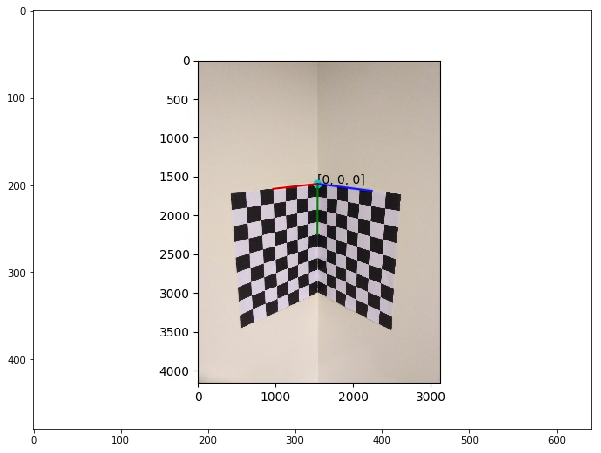

In [4]:
legend_img = cv2.imread('./Camera_calibration_data/calib-object-legend.jpg')
plt.figure(figsize = (10, 10))
plt.imshow(legend_img)
plt.show()

### 3D (x, y, z) coordinates (in mm) of the calibration object

In [ ]:
world_points = [[x,-28,0] for x in range(6*28,0,-56)] #row 1x
world_points += [[x,-56,0] for x in range(6*28,0,-56)] #row 2x
world_points += [[x,-84,0] for x in range(6*28,0,-56)] #row 3x
world_points += [[x,-112,0] for x in range(6*28,0,-56)] #row 4x
world_points += [[x,-140,0] for x in range(6*28,0,-56)] #row 5x
world_points += [[x,-168,0] for x in range(6*28,0,-56)] #row 6x
world_points += [[x,-196,0] for x in range(6*28,0,-56)] #row 7x
world_points += [[x,-224,0] for x in range(6*28,0,-56)] #row 8x
world_points += [[0,-28,z] for z in range(6*28,0,-56)] #row 1z
world_points += [[0,-56,z] for z in range(6*28,0,-56)] #row 2z
world_points += [[0,-84,z] for z in range(6*28,0,-56)] #row 3z
world_points += [[0,-112,z] for z in range(6*28,0,-56)] #row 4z
world_points += [[0,-140,z] for z in range(6*28,0,-56)] #row 5z
world_points += [[0,-168,z] for z in range(6*28,0,-56)] #row 6z
world_points += [[0,-196,z] for z in range(6*28,0,-56)] #row 7z
world_points += [[0,-224,z] for z in range(6*28,0,-56)] #row 8z

### 2D (u, v) coordinates (in pixels) of the image

In [ ]:
image_points = [[2411, 1916], [2075, 1858], [1792, 1805], 
                [2401, 2117], [2068, 2046], [1787, 1981],
                [2390, 2317], [2059, 2231], [1783, 2153],
                [2380, 2508], [2056, 2411], [1780, 2322],
                [2370, 2697], [2052, 2583], [1780, 2485],
                [2362, 2882], [2048, 2757], [1776, 2648],
                [2352, 3058], [2044, 2923], [1777, 2805],
                [2343, 3232], [2041, 3088], [1778, 2960],
                [629, 1904], [977, 1849], [1279, 1801],
                [642, 2106], [983, 2036], [1280, 1976],
                [654, 2301], [989, 2219], [1285, 2147],
                [665, 2493], [997, 2397], [1286, 2314],
                [678, 2680], [1002, 2572], [1288, 2480],
                [687, 2861], [1011, 2745], [1291, 2639],
                [696, 3037], [1020, 2914], [1294, 2798],
                [706, 3212], [1026, 3078], [1299, 2953]]

In [ ]:
def getK(P):
    p = P[:, :3]
    p = np.matmul(p, p.T)
    k = np.zeros([3, 3])
    k[2, 2] = (p[2, 2])**0.5
    k[0, 2] = x = p[0, 2] / k[2, 2]
    k[1, 2] = y = p[1, 2] / k[2, 2]
    try:
        k[1, 1] = fy = (p[1, 1] - y**2)**0.5
    except:
        k[1, 1] = fy = p[1, 1]**0.5

    k[0, 1] = s = (p[1, 0] - x*y) / fy
    k[0, 0] = fx = (p[0, 0] - s**2 - x**2)**0.5
    return k


def DLTCalibrate(world_points, image_points, num_points = 6):    # min. no. of points required for 3D DLT
    point_indices = list(range(len(world_points)))
    random.shuffle(point_indices)
    point_indices = point_indices[:num_points]
    
    world_coords = []
    pixel_coords = []
    for i in point_indices:
        world_coords.append(world_points[i])
        pixel_coords.append(image_points[i])

    world_coords = np.asarray(world_coords)
    pixel_coords = np.asarray(pixel_coords)
        
    A = []
    # convert the points into a corresponding 12 X 12 vector
    for i in range(num_points):
        x, y, z = world_coords[i][0], world_coords[i][1], world_coords[i][2]
        u, v = pixel_coords[i][0], pixel_coords[i][1]

        A.append([x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u])
        A.append([0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v])

    A = np.asarray(A)
    U, S, Vh = np.linalg.svd(A)
    
    P = Vh[-1:]    # The rightmost column of v is the desired solution (min. eigenvalue)
    P = P.reshape(3, 4)    # Camera projection matrix
    P = P / P[-1][-1]

    K = getK(P)
    R = np.matmul(np.linalg.inv(K), P[:, :3])
    T = np.matmul(np.linalg.inv(P[:, :3]), P[:, 3])
    return P, K/K[-1][-1], R, T
    

In [ ]:
Pmat, Kmat, RotMat, Tvec = DLTCalibrate(world_points, image_points, 6)
print("Projection Matrix\n", Pmat)
print("Intrinsic Parameters\n", Kmat)
print("Rotation Matrix\n", RotMat)
print("Translation Vector\n", Tvec)

<br>

## 1.2 RANSAC

Random selection of points from the set of all points, inliers and outliers are differntiated using a threshold values on the
euclidean distance between the actual image point and the point computed from the projectection matrix determined by the
randomly selected points. The best solution with the most inliers is selected

In [ ]:
def getInliersPercentage(P, world_coords, pixel_coords, threshold):    # threshold is in pixel distance
    num_inliers = 0
    for i in range(len(pixel_coords)):
        pc = np.matmul(P, world_coords[i] + [1])
        if np.linalg.norm(pixel_coords[i] - (pc/pc[2])[:2]) < threshold:
            num_inliers += 1
            
    return num_inliers / len(pixel_coords)


def RANSACCalibrate(world_points, image_points, threshold=250, 
                    random_set_size=8, num_iterations=100):
    best_matrices = DLTCalibrate(world_points, image_points, random_set_size)
    best_percentage = getInliersPercentage(best_matrices[0], world_points, image_points, threshold)
    while num_iterations > 0:
        temp_matrices = DLTCalibrate(world_points, image_points, random_set_size)
        temp_percentage = getInliersPercentage(best_matrices[0], world_points, image_points, threshold)
        if temp_percentage > best_percentage:
            best_matrices = temp_matrices
            best_percentage = temp_percentage
            
        num_iterations -= 1
    
    return best_matrices

Pmat, Kmat, RotMat, Tvec = RANSACCalibrate(world_points, image_points, random_set_size=12)
print("Projection Matrix\n", Pmat)
print("Intrinsic Parameters\n", Kmat)
print("Rotation Matrix\n", RotMat)
print("Translation Vector\n", Tvec)

<br>

## 1.3 Radial Distortion

Radial distortion is caused by physical defects in the camera lens which shifts pixels from their original position. The two common type of distortions are barrel distortion and pin-cushion distortion. Both these types of distortions are quatraditc in nature i.e. the amount of distortions increase as we go further from the centre. Opencv uses the following function to calibrate for distorted images.

$$x_{corrected} = x_{actual} (1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$
$$y_{corrected} = y_{actual} (1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$

where <i><b>r</i></b> is the euclidean distance of the distorted point from the distortion center. Opencv provides the cameraCalibration
method which uses a set of point correspondenses on a line to determine the distortions parameters.

In [ ]:
Fig1 = cv2.imread('./Camera_calibration_data/Fig1.png')
plt.figure(figsize = (5, 5))
plt.imshow(Fig1[...,::-1])
plt.show()

In [ ]:
world_points2 = [[x, 0, 0] for x in range(6*28,0,-56)] #row 1x
world_points2 += [[x,-28,0] for x in range(6*28,0,-56)] #row 2x
world_points2 += [[x,-56,0] for x in range(6*28,0,-56)] #row 3x
world_points2 += [[x,-84,0] for x in range(6*28,0,-56)] #row 4x
world_points2 += [[x,-112,0] for x in range(6*28,0,-56)] #row 5x
world_points2 += [[x,-140,0] for x in range(6*28,0,-56)] #row 6x
world_points2 += [[0, 0, z] for z in range(6*28,0,-56)] #row 1z
world_points2 += [[0,-28,z] for z in range(6*28,0,-56)] #row 2z
world_points2 += [[0,-56,z] for z in range(6*28,0,-56)] #row 3z
world_points2 += [[0,-84,z] for z in range(6*28,0,-56)] #row 4z
world_points2 += [[0,-112,z] for z in range(6*28,0,-56)] #row 5z
world_points2 += [[0,-140,z] for z in range(6*28,0,-56)] #row 6z

In [ ]:
image_points2 = [[1853, 177], [1516, 118], [1234, 68], 
                [1843, 378], [1508, 306], [1230, 240],
                [1831, 575], [1501, 489], [1225, 413],
                [1821, 768], [1497, 669], [1221, 580],
                [1812, 956], [1491, 846], [1220, 746],
                [1802, 1141], [1489, 1018], [1217, 909],
                [70, 164], [418, 110], [718, 62],
                [83, 364], [425, 296], [723, 236],
                [95, 563], [431, 479], [724, 410],
                [107, 751], [437, 657], [727, 575],
                [118, 940], [444, 832], [730, 739],
                [129, 1121], [452, 1002], [732, 897]]

In [ ]:
def radialCorrection(world_points, image_points, image):
    world_coords = np.zeros([len(world_points),3],np.float32)
    for p in range(len(world_points)):
        world_coords[p] = [world_points[p][0], world_points[p][1], world_points[p][2]]
    image_coords = np.zeros((len(image_points),2),np.float32)
    for p in range(len(image_points)):
        image_coords[p] = [image_points[p][0], image_points[p][1]]
        
    ret, K, Dist = cv2.calibrateCamera([world_coords], [image_coords], (image.shape[1], image.shape[0]), None, None)[:3]
    K2, roi = cv2.getOptimalNewCameraMatrix(K, Dist, (image.shape[1], image.shape[0]), 1, (image.shape[1], image.shape[0]))
    undistored_image = cv2.undistort(image, K, None, K2)
    return undistored_image, Dist

In [ ]:
undistored_img, Dist = radialCorrection(world_points2[:18], image_points2[:18], Fig1)
print("Distortion Coefficients")
print("k1 = ", Dist[0][0], "k2 = ", Dist[0][1], "k3 = ", Dist[0][4])

In [ ]:
plt.figure(figsize=(10,5))
plt.figure(figsize = (10, 10))
plt.subplot(1,2,1)
plt.imshow(Fig1[...,::-1])
plt.title("Distorted Image")

plt.figure(figsize = (10, 10))
plt.subplot(1,2,2)
plt.title("Undistorted Image")
plt.imshow(undistored_img[...,::-1])
plt.show()

<br>

## Wireframe Model
The wireframe model lets us visualize the set mapping between the real points and image points. If we have correctly
estimated the intrinsic $P$ matrix and the intrinsic parameters we should be able to get the corresponding image frame from the
real world points using the $P$ matrix alone. Overlaying the wire frame model also helps to visually identify how close our
parameters are to the actual parameters of the camera by seeing how well the wirefram fits the acutal points in the image. The
overlay was created by joining a point to its four nearest points.


In [ ]:
# wireframe representaion of image points projected from world points
# w : width of line
# c : color of line
def wireframe(image_points, image, line_width=50, line_color=(0,255,0), close=5):
    px = image.shape[0]
    py = image.shape[1]
    # get 4 closest points to a given point based on euclidean distance to construct wireframe
    for i in image_points:
        npoints = heapq.nsmallest(close, image_points, key = lambda x:((x[0] - i[0])**2 + (x[1] - i[1])**2)**0.5)
        for j in npoints[1:]:
            cv2.line(image, (int(j[0]),int(j[1])), (int(i[0]),int(i[1])), line_color, line_width)

image1 = cv2.imread("./Camera_calibration_data/calib-object.jpg")
image2 = image1.copy()

# wireframe for image points computed from DLT transformation
P, K, R, T = DLTCalibrate(world_points, image_points, 12)
ips = []
for wp in world_points:
    ip_ = np.matmul(P, wp + [1])
    ips += [(ip_/ip_[2])]

wireframe(ips, image1, line_width=5)
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(image1[...,::-1])
plt.title("DLT Wireframe")
plt.show()

# wireframe for image points computed from random sampling dlt transformation
P, K, R, T = RANSACCalibrate(world_points, image_points, random_set_size=24)
ips = []
for wp in world_points:
    ip_ = np.matmul(P, wp + [1])
    ips += [(ip_/ip_[2])]

wireframe(ips, image2, line_width=5)
plt.figure(figsize = (20,20))
plt.subplot(1,2,2)
plt.imshow(image2[...,::-1])
plt.title("Ransac DLT Wireframe")
plt.show()

<br>

## 2.1 Zhangs Camera Calibration using OpenCV

In [ ]:
def ZhangsCalibrate(images, grid, square_size = 29):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)
    #world points
    wp = np.zeros((grid[0]*grid[1], 3), np.float32)
    for i in range(grid[1]):
        for j in range(grid[0]):
            wp[i*grid[0] + j] = (i*square_size, j*square_size, 0)

    world_points = []
    image_points = []
    for image in images:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret,corners = cv2.findChessboardCorners(image, grid, None)
        if ret:
            cv2.cornerSubPix(image,corners,(11,11),(-1,-1),criteria)
            world_points.append(wp)
            image_points.append(corners)

    return (wp,cv2.calibrateCamera(world_points,image_points,(images[0].shape[1], images[0].shape[0]),None,None))

In [ ]:
chessImgSet = [cv2.imread("./Camera_calibration_data/IMG_54" + str(i) + ".JPG") for i in range(56,71)]
points,(ret,kmat,dist,rmat,tvec) = ZhangsCalibrate(chessImgSet, (6, 8), square_size=29)
print("Camera Matrix using zhangs")
print(kmat)

<br>

## 2.2 Wireframe representation of checkerboard

In [ ]:
wfp = cv2.projectPoints(points,rmat[0],tvec[0],kmat,dist)
ips = []
for i in wfp[0]:
    ips += [i[0].tolist()]

image = cv2.imread("./Camera_calibration_data/IMG_5456.JPG")
wireframe(ips,  image,line_width=10, line_color=(0,255,0), close=4)
plt.figure(figsize = (20,20))
plt.imshow(image)
plt.show()

<br>

## 2.3 Finding the origin

In [ ]:
image = cv2.imread("./Camera_calibration_data/calib-object.jpg")
P, K, R, T = DLTCalibrate(world_points, image_points, 12)
ip_ = np.matmul(P, [0, 0, 0, 1])
cv2.circle(image, (int(ip_[0]), int(P[)), 50, (0, 255, 0), -1)
plt.figure(figsize = (10, 10))
plt.imshow(image[..., ::-1])
plt.title("World center (green dot)")
plt.show()

<br>

<br>

## 3.1 Own Camera Calibration

In [ ]:
Fig2 = cv2.imread('./Camera_calibration_data/20200212_152612.jpg')
plt.figure(figsize = (5, 5))
plt.imshow(Fig2[...,::-1])
plt.show()

In [ ]:
world_points3 = [[4, 0, -4], [4, 0, -25], [296, 0, -25], [296, 0, -4],
                 [0, 4, -4], [0, 4, -25], [0, 196, -25], [0, 196, -4],
                 [8, 8, 0], [56, 8, 0], [104, 8, 0], [180, 8, 0],
                 [296, 8, 0], [14, 50, 0], [52, 50, 0], [100, 50, 0],
                 [148, 50, 0], [285, 56, 0], [112, 78, 0], [192, 78, 0],
                 [192, 126, 0], [112, 126, 0], [300, 208, 0], [4, 208, 0]]

In [ ]:
image_points3 = [[1605, 2655], [1619, 2868], [3179, 1879], 
                 [3201, 1730], [1516, 2654], [1523, 2864], 
                 [342, 2129], [324, 1961], [1563, 2550], 
                 [1945, 2339], [2263, 2164], [2710, 1920], 
                 [3139, 1685], [1292, 2348], [1666, 2182],
                 [1982, 2041], [2253, 1912], [2786, 1644],
                 [1803, 1969], [2219, 1781], [1944, 1699],
                 [1517, 1858], [2028, 1413], [360, 1909]]

### DLT

In [ ]:
P, K, R, T = DLTCalibrate(world_points3, image_points3, 24)
print ("Camera Matrix")
print (K)
image = cv2.imread("./Camera_calibration_data/20200212_152612.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
ips = []
for i in range(len(world_points3)):
    ip_ = np.matmul(P, world_points3[i] + [1])
    ips += [ip_/ip_[2]]

wireframe(ips, image, line_width=5, line_color=(0,255,0),close=6)
plt.figure(figsize=(10,7))
plt.imshow(image)
plt.show()

### RANSAC DLT

In [ ]:
P, K, R, T = RANSACCalibrate(world_points3, image_points3, random_set_size=24)
print("Camera Matrix")
print(K)
image = cv2.imread("./Camera_calibration_data/20200212_152612.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
ips = []
for i in range(len(world_points3)):
    ip_ = np.matmul(P, world_points3[i] + [1])
    ips += [ip_/ip_[2]]

wireframe(ips,image, line_width=5, line_color=(0,255,0),close=6)
plt.figure(figsize=(10,7))
plt.imshow(image)
plt.show()